# pg_server_configuration_and_extnensions
Shows the configuration of the PostgreSQL server (from ``pg_settings``) and installed extensions. 
The cloud vendors Postgres, such as AWS RDS and Google Cloud SQL, do not allow access to the host Operating System. Instead, you'll have to provide different credentials, to the cloud API. This notebook uses SQL only to work with any PostgreSQL server, regardless whether it is in the cloud or a Docker container. We created AWS notebooks. 

## Cells
- Configuration - a connection string
- PostgreSQL Configuration 
- Installed Extensions 

## Configuration
Open a connection to the DB. Use a Connection String stored in a .cfg file

In [1]:
import sqlalchemy
import psycopg2
import pandas as pd
import configparser
import matplotlib.pyplot as plt 

# Read from the Config file
config = configparser.ConfigParser() 
config.read_file(open(r'../ipynb.cfg'))
con_str = config.get('con_str', 'PG_PLATFORM') 
engine = sqlalchemy.create_engine(con_str)

# print("Connecting with engine " + str(engine))
try:
    connection = engine.connect()
except (Exception, sqlalchemy.exc.SQLAlchemyError) as error:
    print("Error while connecting to PostgreSQL database:", error)

## PostgreSQL Configuration
The view ``pg_settings`` provides access to run-time parameters of the server. It is essentially an alternative interface to the SHOW and ``SET`` commands. It also provides access to some facts about each parameter that are not directly available from ``SHOW``, such as minimum and maximum values.
https://www.postgresql.org/docs/current/view-pg-settings.html

In [3]:
qry_pg_settings = """
SELECT category, name, setting, unit, short_desc 
FROM pg_settings
"""

df = pd.read_sql_query(qry_pg_settings, connection)
df

,category,name,setting,unit,short_desc
0,Developer Options,allow_in_place_tablespaces,off,None,"Allows tablespaces directly inside pg_tblspc, ..."
1,Developer Options,allow_system_table_mods,off,None,Allows modifications of the structure of syste...
2,Reporting and Logging / What to Log,application_name,,None,Sets the application name to be reported in st...
3,Write-Ahead Log / Archive Recovery,archive_cleanup_command,,None,Sets the shell command that will be executed a...
4,Write-Ahead Log / Archiving,archive_command,,None,Sets the shell command that will be called to ...
...,...,...,...,...,...
395,Write-Ahead Log / Settings,wal_writer_flush_after,128,8kB,Amount of WAL written out by WAL writer that t...
396,Resource Usage / Memory,work_mem,4096,kB,Sets the maximum memory to be used for query w...
397,Client Connection Defaults / Statement Behavior,xmlbinary,base64,None,Sets how binary values are to be encoded in XML.
398,Client Connection Defaults / Statement Behavior,xmloption,content,None,Sets whether XML data in implicit parsing and ...


## Installed Extensions
The catalog pg_extension stores information about the installed extensions. https://www.postgresql.org/docs/current/catalog-pg-extension.html
We recommend installing the following extensions: 
- pg_stat_statements
- pg_cron
- pg_buffercache

TODO - move this from the server level to the DB level, as each DB might have different extensions installed. 

In [7]:
qry_extensions = """
SELECT * 
FROM pg_extension;
"""

df = pd.read_sql_query(qry_extensions, connection)
df

,oid,extname,extowner,extnamespace,extrelocatable,extversion,extconfig,extcondition
0,14498,plpgsql,10,11,False,1.0,None,None
1,16551,pg_trgm,10,16548,True,1.5,None,None
2,16553,postgres_fdw,10,16548,True,1.0,None,None
3,2691727,log_fdw,10,16548,True,1.3,None,None
4,2824922,pg_stat_statements,10,16548,True,1.10,None,None


### Buffers used by each DB - Pie Chart

<Figure size 1000x600 with 0 Axes>

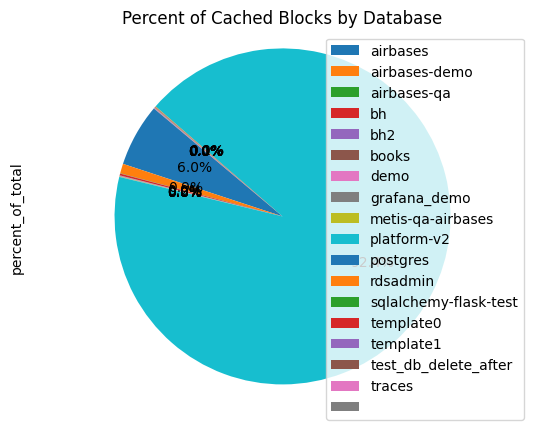

In [10]:
plt.figure(figsize=(10, 6))
df.plot.pie(y="percent_of_total", autopct="%1.1f%%", startangle=140, labels=[None] * len(df))
plt.axis("equal")  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.title("Percent of Cached Blocks by Database")
plt.legend(labels=df["database"], loc="upper right")
plt.show()

## Tables (in a single DB) Cache Hit Ratio.
Postgres caches recent queries in memory called the shared buffer cache (shared_buffers in postgresql.conf). The pg_statio_user_tables has as rows representing various stats on each of the (user) tables. The two columns of interest we’ll be looking at are:

* pg_statio_user_tables.heap_blks_read — Number of disk blocks read from a table (ie. missed cache)
* pg_statio_user_tables.heap_blks_hits — Number of buffer hits from this table (ie. cache hit)


In [ ]:
query_ccnnections_metrics = """
SELECT 
  schemaname, 
  pg_class.relname, 
  ROUND(
    CASE 
      WHEN heap_blks_hit + heap_blks_read = 0 
      THEN 0 
      ELSE heap_blks_hit::decimal / (heap_blks_hit + heap_blks_read) 
    END, 
    3
  ) as cache_hit_ratio
FROM 
  pg_statio_user_tables 
  JOIN pg_class ON pg_statio_user_tables.relid = pg_class.oid 
  JOIN pg_namespace ON pg_namespace.oid = pg_class.relnamespace;
"""

df = pd.read_sql_query(query_ccnnections_metrics, connection)
df

,schemaname,relname,cache_hit_ratio
0,metis,pg_stat_database_snapshots,0.886
1,metis,queries,0.997
2,metis,pg_stat_tables_activity_snapshots,0.917
3,cron,job,0.579
4,logs,postgres_logs,0.000
5,public,sales_table,0.991
6,metis,postgres_server_settings,0.000
7,metis_qa,test_high_indexes_num,0.000
8,postgres_air,aircraft,0.000
9,postgres_air,airport,0.773
